In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("data/segmentation_Test.csv")
df_test = pd.read_csv("data/segmentation_Test.csv")

In [4]:
df_train.describe()

,ID,Age,Work_Experience,Family_Size
count,2627.000000,2627.000000,2358.000000,2514.000000
mean,463433.918919,43.649791,2.552587,2.825378
std,2618.245698,16.967015,3.341094,1.551906
min,458989.000000,18.000000,0.000000,1.000000
25%,461162.500000,30.000000,0.000000,2.000000
50%,463379.000000,41.000000,1.000000,2.000000
75%,465696.000000,53.000000,4.000000,4.000000
max,467968.000000,89.000000,14.000000,9.000000


In [5]:
pd.concat([df_train.dtypes.to_frame(3).T, df_train.head(2)])

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
3,int64,object,object,int64,object,object,float64,object,float64,object
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6


In [6]:
df_train.groupby(["Gender", "Graduated"]).size()

Gender  Graduated
Female  No           423
        Yes          771
Male    No           578
        Yes          831
dtype: int64

# EDA and Preprocessing

## Impute null

In [56]:
df_train.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
# train
numeric_cols = df_train.select_dtypes(include=["number"]).columns
non_numeric_cols = df_train.select_dtypes(exclude=["number"]).columns

df_train[numeric_cols] = df_train[numeric_cols].fillna(df_train[numeric_cols].mean())
df_train[non_numeric_cols] = df_train[non_numeric_cols].fillna(df_train[non_numeric_cols].mode().T[0].to_dict())

# test
df_test[numeric_cols] = df_test[numeric_cols].fillna(df_train[numeric_cols].mean())
non_numeric_cols2 = [col for col in non_numeric_cols if col in df_test]
df_test[non_numeric_cols2] = df_test[non_numeric_cols2].fillna(df_train[non_numeric_cols2].mode().T[0].to_dict())

In [8]:
df_train.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

## EDA

<Axes: xlabel='Spending_Score'>

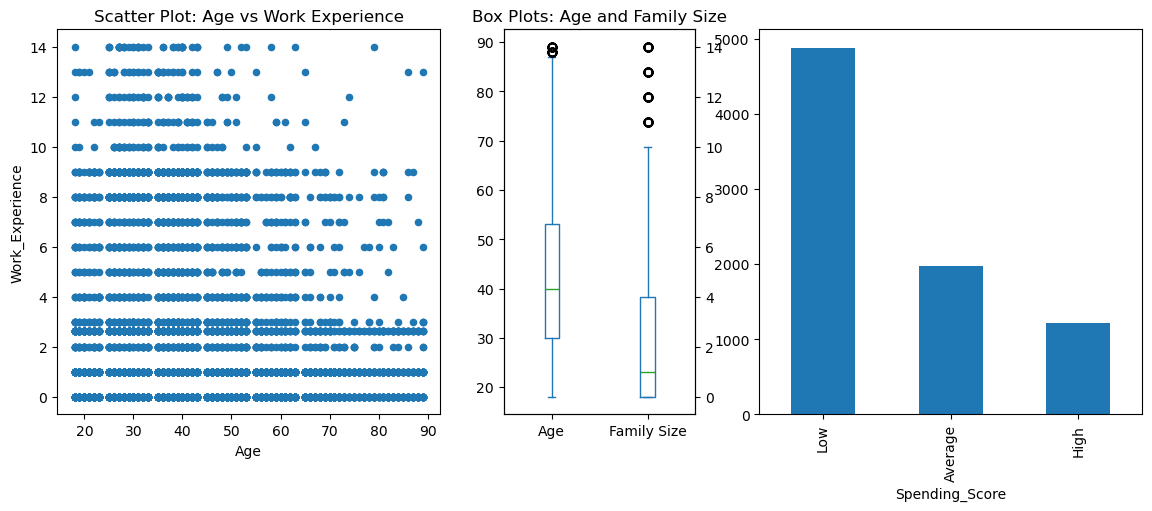

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1,2]})
df_train.plot.scatter("Age", "Work_Experience", ax=axes[0])
axes[0].set_title("Scatter Plot: Age vs Work Experience")

df_train["Age"].plot.box(ax=axes[1], positions=[1])
ax2 = axes[1].twinx()
df_train["Work_Experience"].plot.box(positions=[2])

axes[1].set_title("Box Plots: Age and Family Size")
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(["Age", "Family Size"])

df_train["Spending_Score"].value_counts().plot.bar(ax=axes[2])


Data has issues, 20 years old and 14 years of experience is weird

Text(0.5, 1.0, 'Spending Score')

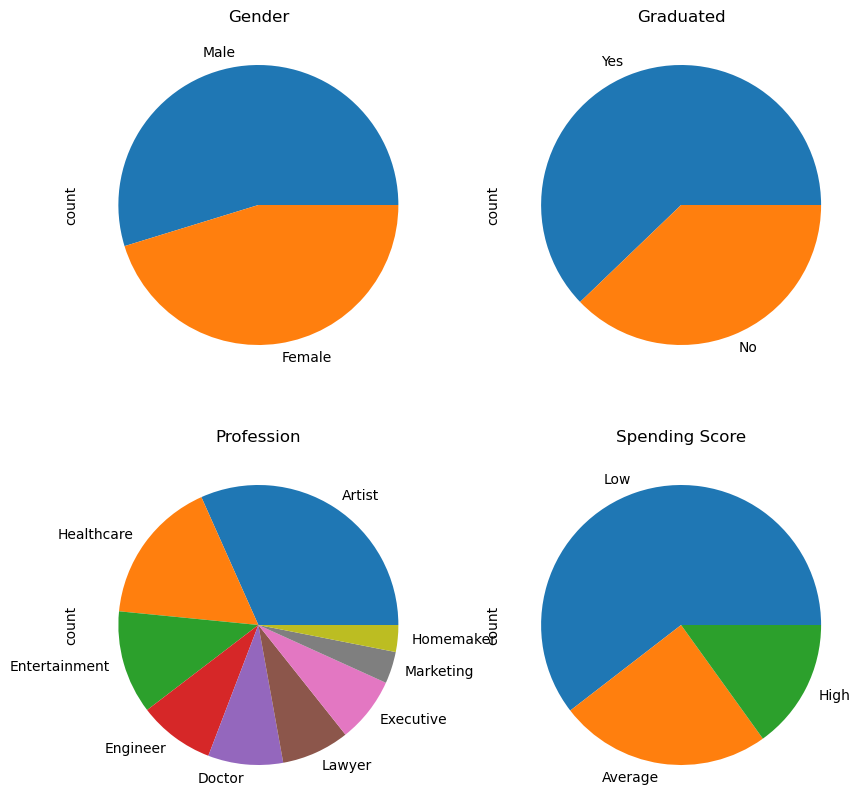

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (10,10))

pd.crosstab(df_train["Gender"], df_train["Graduated"])

df_train["Gender"].value_counts().plot.pie(ax=axes[0, 0])
axes[0, 0].set_title("Gender")  

df_train["Graduated"].value_counts().plot.pie(ax=axes[0, 1])
axes[0, 1].set_title("Graduated")  

df_train["Profession"].value_counts().plot.pie(ax=axes[1, 0])
axes[1, 0].set_title("Profession")  

df_train["Spending_Score"].value_counts().plot.pie(ax=axes[1, 1])
axes[1, 1].set_title("Spending Score")  

## Convert categorical to numeric


- One-hot encoding (a few categories)
- label encoding (ordinal data)
- target encoding (mean of the target variable for each category)
- frequency encoding (frequency of each category)
- hashing (hashing trick), especially when categories are too numerous


In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
numeric_features = ['Age', 'Work_Experience','Family_Size',] 
binary_features = ['Gender', 'Ever_Married',  'Graduated' ] # label encoding
one_hot_features = ['Profession'] # one-hot encoding
ordinal_features = ['Spending_Score'] # target encoding

all_features = numeric_features + binary_features + one_hot_features + ordinal_features
X_train = df_train[all_features].copy()
X_test = df_test[all_features].copy()



for col in binary_features + ordinal_features:
    le = LabelEncoder()
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col]) 

one_hot_encoder = OneHotEncoder(sparse_output=False )
X_train_one_hot = one_hot_encoder.fit_transform(X_train[one_hot_features])
X_train_one_hot = pd.DataFrame(X_train_one_hot, columns=one_hot_encoder.get_feature_names_out())
X_train = pd.concat([X_train[numeric_features], X_train_one_hot], axis=1)
X_test_one_hot = one_hot_encoder.transform(X_test[one_hot_features])
X_test_one_hot = pd.DataFrame(X_test_one_hot, columns=one_hot_encoder.get_feature_names_out())
X_test = pd.concat([X_test[numeric_features], X_test_one_hot], axis=1)


# Clustering 1 KMean

For KNN since it is euclidean distance, we standardize all columns



In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_train)

## Determine K using Elbow method to 


 WCSS = within-cluster sum of squares

In [29]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
os.environ["OMP_NUM_THREADS"] = "11"



In [30]:
from sklearn.cluster import KMeans
wcss = {}
for k in range(1,11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    wcss[k] = km.inertia_


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Win

Text(0, 0.5, 'WCSS')

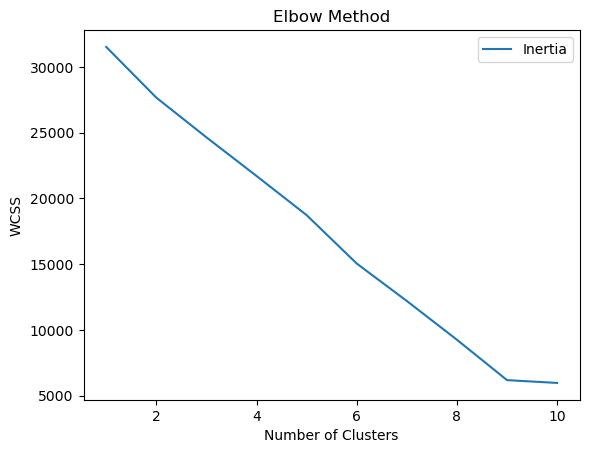

In [31]:
pd.Series(wcss).to_frame("Inertia").plot()
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

In [131]:
# k=9 is selected using elbow method

In [32]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(df_scaled)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [33]:
pd.concat([df_train, pd.Series(km.labels_).to_frame("cluster")], axis=1)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,cluster
0,458989,Female,Yes,36,Yes,Engineer,0.000000,Low,1.0,Cat_6,3
1,458994,Male,Yes,37,Yes,Healthcare,8.000000,Average,4.0,Cat_6,0
2,458996,Female,Yes,69,No,Artist,0.000000,Low,1.0,Cat_6,0
3,459000,Male,Yes,59,No,Executive,11.000000,High,2.0,Cat_6,0
4,459001,Female,No,19,No,Marketing,2.552587,Low,4.0,Cat_6,0
...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.000000,Low,4.0,Cat_6,0
2623,467958,Female,No,35,Yes,Doctor,1.000000,Low,1.0,Cat_6,0
2624,467960,Female,No,53,Yes,Entertainment,2.552587,Low,2.0,Cat_6,2
2625,467961,Male,Yes,47,Yes,Executive,1.000000,High,5.0,Cat_4,0


## Determining k Using Silhouette method

Silhouette scores measure how well-separated the clusters are.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Win

Text(0, 0.5, 'Score')

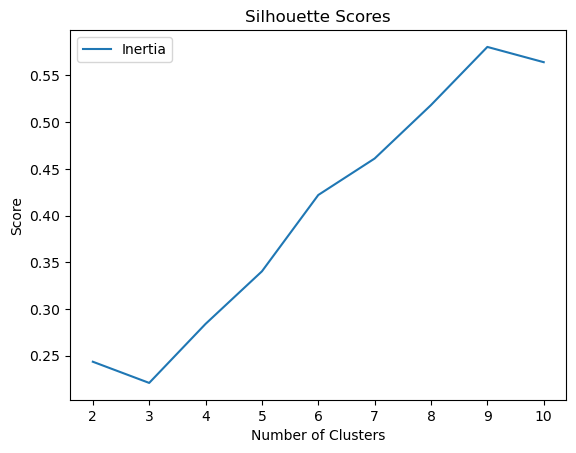

In [34]:
from sklearn.metrics import silhouette_score

sil_scores = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    sil_scores[k] = silhouette_score(df_scaled, labels)

pd.Series(sil_scores).to_frame("Inertia").plot()

plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')


Silhouette score confirms k=9


## DBSCAN Density-Based Spatial Clustering of Applications with Noise

- It groups together points that are close to each other based on a predefined 
distance metric and a minimum number of points in a neighborhood. 
- Points in low-density regions are labeled as noise. 


- Automatically determines the number of clusters. 
- Handles noise and outliers effectively. 
- Works well for clusters of arbitrary shapes, unlike K-Means, which assumes spherical clusters. 
Limitations: 
- Sensitive to the choice of eps and min_samples 
- Struggles with datasets where clusters vary significantly in density. 



In [56]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=1, min_samples=10)
labels_dbscan = model.fit_predict(df_scaled)

In [42]:
pd.Series(labels_dbscan).unique()

array([ 0,  1,  2, -1,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [44]:
df_res = pd.concat([df_train, pd.Series(labels_dbscan).to_frame("cluster")], axis=1)
df_res.head(2)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,cluster
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,0
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,1


In [50]:
print(f"percent of noise classified data {df_res[df_res["cluster"].eq(-1)].shape[0]/df_res.shape[0] :.02f}")


percent of noise classified data 0.04


# Gaussian Mixture Model (GMM)

MM assumes that the entire dataset is generated from a mixture of several Gaussian distributions, each with its own mean (μ), covariance (Σ), and mixing coefficient (π). </br>
 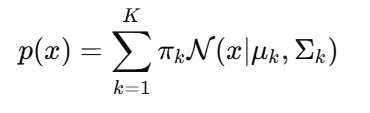

 Applications are:
 - clustering
 - anomaly detection
 - density estimation

In [53]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, random_state=42)
# Feature Scaling Matters in GMM
gmm.fit(df_scaled)
labels_gmm = gmm.predict(df_scaled)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [52]:
labels_gmm

array([3, 0, 0, ..., 2, 0, 0], dtype=int64)

# Winner


In [57]:
sil_score_final = {}
sil_score_final["GMM"] = silhouette_score(df_scaled, labels_gmm)
sil_score_final["KM"] = sil_scores[9]
sil_score_final["DBSCAN"] = silhouette_score(df_scaled,labels_dbscan)


Text(0.5, 1.0, 'Silhouette score of the models')

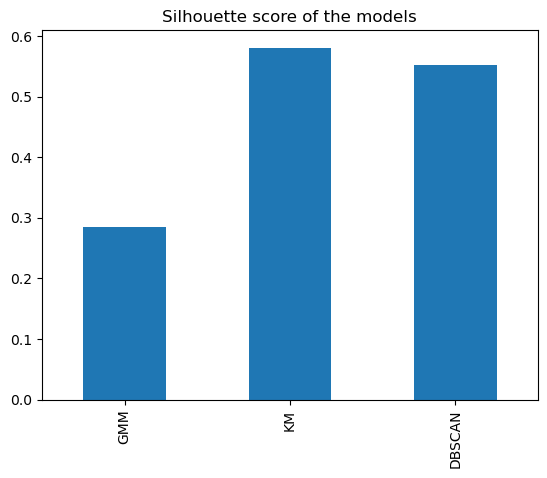

In [62]:
pd.Series(sil_score_final).plot.bar()
plt.title("Silhouette score of the models")

# Visualize Clusters

In [ ]:
from sklearn.manifold import TSNE
ts = TSNE(n_components=2, random_state=42, perplexity=30 , learning_rate=200)
# perplexity : Controls how t-SNE balances local and global structure. Typical values range from 5 to 50.
reduced_data = ts.fit_transform(df_scaled)

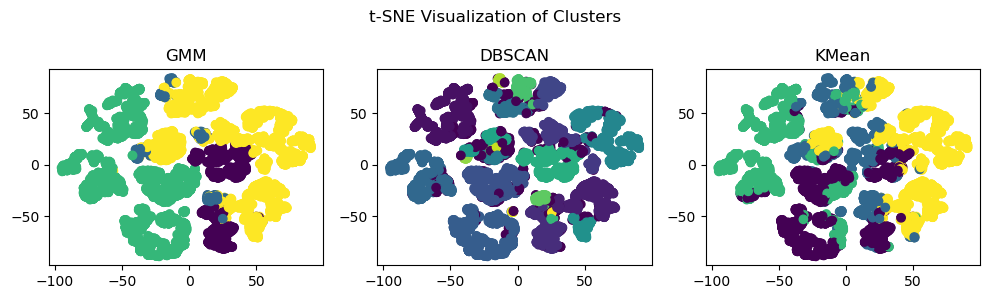

In [163]:
fig, axes = plt.subplots(1,3,figsize=(10,3))
axes[0].scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_gmm, cmap='viridis', marker='o')
axes[0].set_title("GMM")
axes[1].scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_dbscan, cmap='viridis', marker='o')
axes[1].set_title("DBSCAN")
axes[2].scatter(reduced_data[:, 0], reduced_data[:, 1], c=km.labels_, cmap='viridis', marker='o')
axes[2].set_title("KMean")
plt.suptitle("t-SNE Visualization of Clusters")
plt.tight_layout()
